# GRAPE for CNOT

In [3]:
# ruff: noqa

"""
Gradient Ascent Pulse Engineering (GRAPE)
"""

import jax.numpy as jnp
import sys

sys.path.append('../../../feedback_grape')
from grape import optimize_pulse, plot_control_amplitudes
from utils.gates import cnot
from utils.operators import identity, sigmax, sigmay, sigmaz
from utils.tensor import tensor

# Example usage
g = 0  # Small coupling strength
H_drift = g * (tensor(sigmax(), sigmax()) + tensor(sigmay(), sigmay()))
H_ctrl = [
    tensor(sigmax(), identity(2)),
    tensor(sigmay(), identity(2)),
    tensor(sigmaz(), identity(2)),
    tensor(identity(2), sigmax()),
    tensor(identity(2), sigmay()),
    tensor(identity(2), sigmaz()),
    tensor(sigmax(), sigmax()),
    tensor(sigmay(), sigmay()),
    tensor(sigmaz(), sigmaz()),
]

U_0 = identity(4)
# Target operator (CNOT gate)
C_target = cnot()

num_t_slots = 500
total_evo_time = 2 * jnp.pi

# Run optimization
result = optimize_pulse(
    H_drift,
    H_ctrl,
    U_0,
    C_target,
    num_t_slots,
    total_evo_time,
    max_iter=0,
    learning_rate=1e-2,
    optimizer="l-bfgs",
)
print("final_fidelity: ", result.final_fidelity)
print("U_f \n", result.final_operator)
print("Converged after: ", result.iterations)

final_fidelity:  0.25004711215524955
U_f 
 [[ 9.94315600e-01+0.04703143j -1.09078148e-02+0.03408383j
  -6.90552189e-02-0.00098322j  9.61271437e-04-0.05543762j]
 [ 4.70451116e-03+0.03357198j  9.88592573e-01+0.10586841j
  -1.34806757e-02-0.0768908j  -6.50634827e-02+0.00046342j]
 [ 7.31897232e-02-0.00759006j  9.95419382e-03-0.07245311j
   9.83957148e-01-0.14043013j -2.92064799e-03+0.03655538j]
 [ 1.82565446e-03-0.05057316j  6.92435955e-02+0.00725959j
   7.63055865e-03+0.03443794j  9.95589903e-01-0.01217351j]]
Converged after:  0


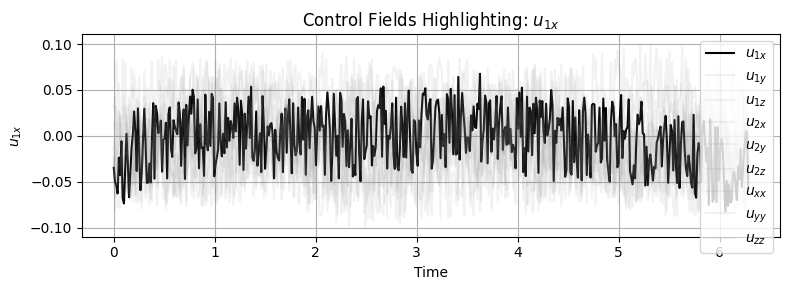

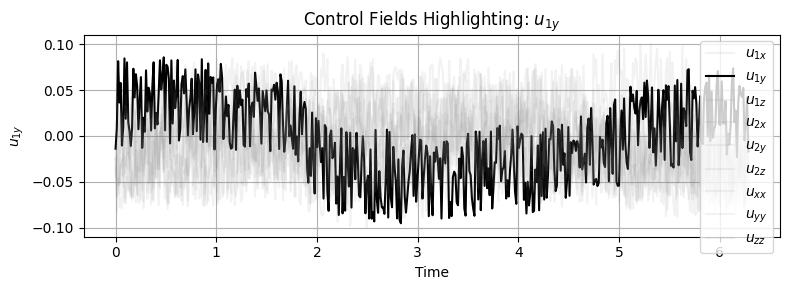

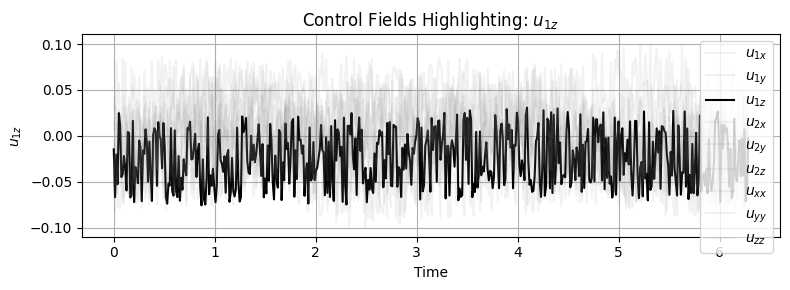

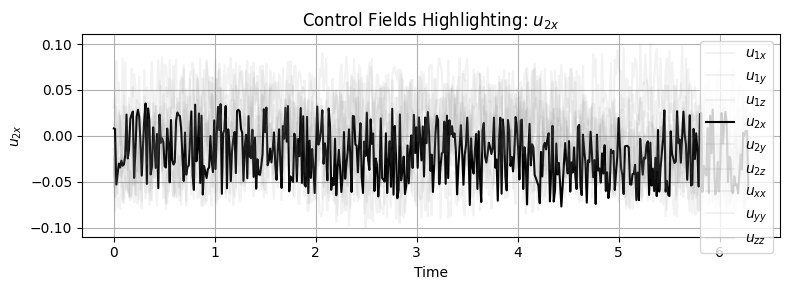

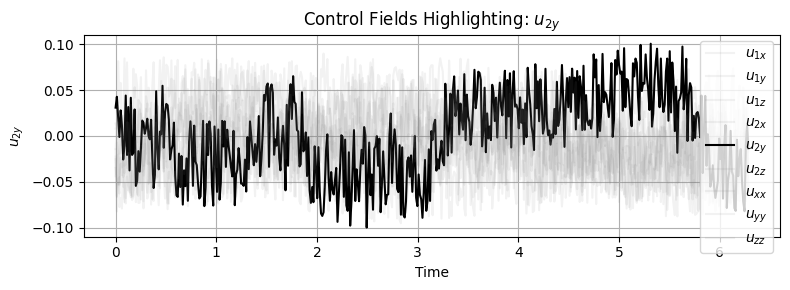

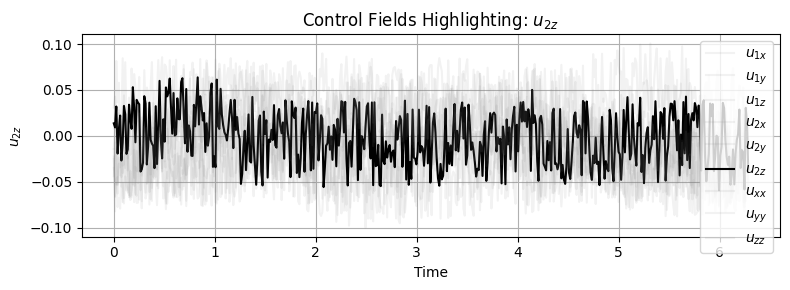

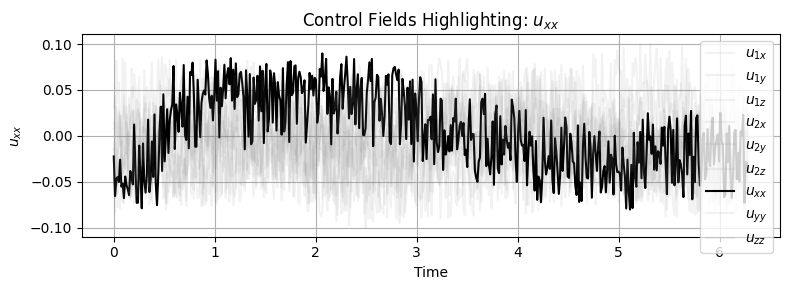

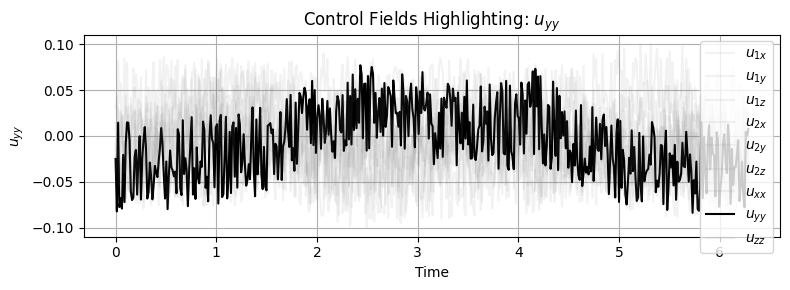

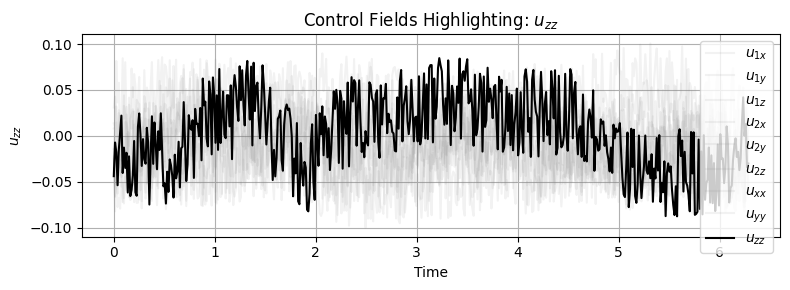

In [2]:
times = jnp.linspace(0, 2 * jnp.pi, 500)
H_labels = [
    r'$u_{1x}$',
    r'$u_{1y}$',
    r'$u_{1z}$',
    r'$u_{2x}$',
    r'$u_{2y}$',
    r'$u_{2z}$',
    r'$u_{xx}$',
    r'$u_{yy}$',
    r'$u_{zz}$',
]
plot_control_amplitudes(
    times, result.control_amplitudes / (2 * jnp.pi), H_labels
)

In [3]:
U_target = cnot()
U_f = result.final_operator

In [4]:
def overlap(U_target, U_f):
    """
    Calculate the overlap between the target unitary U_target and the final unitary U_f.

    Parameters:
    U_target (qutip.Qobj): Target unitary operator.
    U_f (qutip.Qobj): Final unitary operator.

    Returns:
    float: Real part of the overlap value.
    float: Fidelity (absolute square of the overlap).
    """
    # dividing over U_target.shape[0] is for normalization
    overlap_value = (
        jnp.trace(jnp.matmul(U_target.conj().T, U_f)) / U_target.shape[0]
    )
    fidelity = abs(overlap_value) ** 2
    return overlap_value.real, fidelity


# Example usage
overlap_real, fidelity = overlap(U_target, U_f)
print(f"Overlap (real part): {overlap_real}")
print(f"Fidelity: {fidelity}")

Overlap (real part): 0.7071028736035011
Fidelity: 0.9999889463518875
